<a href="https://colab.research.google.com/github/farenga/neuralODEs/blob/main/3_GP_NODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [47]:
!pip install numpyro

In [48]:
import math

import jax.numpy as np
import jax.random as random
from jax import vmap, jit
from jax.experimental.ode import odeint
from jax.config import config
config.update("jax_enable_x64", True)

from numpyro import sample
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS

import numpy as onp
import matplotlib.pyplot as plt
from functools import partial
import time

In [49]:
class ODE_GP:
    # Initialize the class
    def __init__(self, t, i_t, X_train_ff, x0, dxdt, ind):    
        # Normalization 
        self.t = t
        self.x0 = x0
        self.i_t = i_t
        self.dxdt = dxdt      
        self.jitter = 1e-8
        self.ind = ind
        
        self.max_t = t.max(0)
        
        self.max_X = []
        self.X = []
        self.N = []
        self.D = len(i_t)
        self.t_t = []
        for i in range(len(i_t)):
            self.max_X.append(np.abs(X_train_ff[i]).max(0))
            self.X.append(X_train_ff[i] / self.max_X[i])
            self.N.append(X_train_ff[i].shape[0])
            self.t_t.append(t[self.i_t[i]]/self.max_t)
        
    @partial(jit, static_argnums=(0,))     
    def RBF(self,x1, x2, params):
        diffs = (x1 / params).T - x2 / params
        return np.exp(-0.5 * diffs**2)

    def model(self, t, X):        
        
        noise = sample('noise', dist.LogNormal(0.0, 1.0), sample_shape=(self.D,))
        hyp = sample('hyp', dist.Gamma(1.0, 0.5), sample_shape=(self.D,))
        W = sample('W', dist.LogNormal(0.0, 1.0), sample_shape=(self.D,))
        
        M = 7*2
        m0 = 13
        sigma = 1
        
        tau0 = (m0/(M-m0) * (sigma/np.sqrt(1.0*self.D*sum(self.N))))
        
        tau_tilde = sample('tau_tilde', dist.HalfCauchy(1.), sample_shape=(self.D,))
        tau = np.repeat(tau0 * tau_tilde,M//self.D)
        
        slab_scale=1
        slab_scale2 = slab_scale**2
        
        slab_df=1
        half_slab_df = slab_df/2
        c2_tilde = sample('c2_tilde', dist.InverseGamma(half_slab_df, half_slab_df))
        c2 = slab_scale2 * c2_tilde
        
        lambd = sample('lambd', dist.HalfCauchy(1.), sample_shape=(M,))
        lambd_tilde = tau**2 * c2 * lambd**2 / (c2 + tau**2 * lambd**2)
        par = sample('par', dist.MultivariateNormal(np.zeros(M,), np.diag(lambd_tilde)))
        
        IC = sample('IC', dist.Uniform(4, 6))
        
        # compute kernel
        K_11 = W[0]*self.RBF(self.t_t[0], self.t_t[0], hyp[0]) + np.eye(self.N[0])*(noise[0] + self.jitter)
        K_22 = W[1]*self.RBF(self.t_t[1], self.t_t[1], hyp[1]) + np.eye(self.N[1])*(noise[1] + self.jitter)
        K = np.concatenate([np.concatenate([K_11, np.zeros((self.N[0], self.N[1]))], axis = 1),
                            np.concatenate([np.zeros((self.N[1], self.N[0])), K_22], axis = 1)], axis = 0)
        
        # compute mean
        x0 = np.array([IC, 5.0])
        mut = odeint(self.dxdt, x0, self.t.flatten(), par)
        mu1 = mut[self.i_t[0],ind[0]] / self.max_X[0]
        mu2 = mut[self.i_t[1],ind[1]] / self.max_X[1]
        mu = np.concatenate((mu1,mu2),axis=0)
        mu = mu.flatten('F')
        
        X = np.concatenate((self.X[0],self.X[1]),axis=0)
        X = X.flatten('F')
        
        # sample X according to the standard gaussian process formula
        sample("X", dist.MultivariateNormal(loc=mu, covariance_matrix=K), obs=X)
        
    # helper function for doing hmc inference
    def train(self, settings, rng_key):
        start = time.time()
        kernel = NUTS(self.model, 
                      target_accept_prob = settings['target_accept_prob'])
        mcmc = MCMC(kernel, 
                    num_warmup = settings['num_warmup'], 
                    num_samples = settings['num_samples'],
                    num_chains = settings['num_chains'],
                    progress_bar=True,
                    jit_model_args=True)
        mcmc.run(rng_key, self.t, self.X)
        mcmc.print_summary()
        elapsed = time.time() - start
        print('\nMCMC elapsed time: %.2f seconds' % (elapsed))
        return mcmc.get_samples()
    
    @partial(jit, static_argnums=(0,))     
    def predict(self, t_star, par, IC):
        x0_l = np.array([IC, 5.0])
        X = odeint(self.dxdt, x0_l, t_star, par)
        return X

In [50]:
plt.rcParams.update(plt.rcParamsDefault)
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 16,
                     'lines.linewidth': 2,
                     'axes.labelsize': 20,
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 20,
                     'axes.linewidth': 2,
                     "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
                     "text.usetex": True,                # use LaTeX to write all text
                     })

In [51]:
def LV(x, t, alpha, beta, gamma, delta):
    x1, x2 = x
    dxdt = [alpha*x1+beta*x1*x2, delta*x1*x2+gamma*x2]
    return dxdt

def LV_dict(x, t, par):
    x1, x2 = x
    dxdt = [par[1]*x1 + par[2]*x2 + par[3]*x1*x2 + par[4]*x1**2 + par[5]*x2**2 + par[6]*x1**3 + par[0]*x2**3,
            par[9]*x1 + par[10]*x2 + par[11]*x1*x2 + par[12]*x1**2 + par[13]*x2**2 + par[8]*x1**3 + par[7]*x2**3]
    return dxdt

In [52]:
key = random.PRNGKey(123)
D = 2
alpha = 1.0
beta = -0.1
gamma = -1.5
delta = 0.75
IC = 5.0
noise = 0.1
N = 110 
N_fine = 1100 
Tf = 16.5
Tf_test = 30
x0 = np.array([5.0, IC])

In [53]:
# Training data
t_fine = np.linspace(0, Tf, N_fine+1)
X_fine = odeint(LV, x0, t_fine, alpha, beta, gamma, delta)
X_fine_noise = X_fine + noise*X_fine.std(0)*random.normal(key, X_fine.shape)

t = t_fine[np.array(range(0, N_fine+1, N_fine//N))]
X_train = X_fine_noise[np.array(range(0, N_fine+1, N_fine//N)),:]

In [54]:
# Test data
t_star = np.linspace(0, Tf_test, 2*N_fine+1)
X_star = odeint(LV, x0, t_star, alpha, beta, gamma, delta)

In [55]:
gap = 9
ind_t = np.array([0])
ind_t = np.concatenate([ind_t[:,None],np.arange(gap+1,N+1)[:,None]])
ind_t = ind_t[:,0]

j1 = np.array(range(0, ind_t.shape[0]+1, 2))
j2 = np.array([0]) + np.array( range(1, ind_t.shape[0]+1, 2) )
i1 = ind_t[j2]
i2 = ind_t[j1]
i1 = i1[1:]

i_t_plot = []
i_t_plot.append(i1)
i_t_plot.append(i2)

i_t = []
i_t.append(i1)
i_t.append(i2)

ind = [0,1]

In [56]:
X1_train = X_train[i_t[0],ind[0]]
X2_train = X_train[i_t[1],ind[1]]

X_train_ff = []
X_train_ff.append(X1_train)
X_train_ff.append(X2_train)

In [57]:
model = ODE_GP(t[:,None], i_t, X_train_ff, x0, LV_dict, ind)

In [58]:
rng_key_train, rng_key_predict = random.split(random.PRNGKey(123))

num_warmup = 1000 #4000
num_samples = 2000 #8000
num_chains = 1
target_accept_prob = 0.85
settings = {'num_warmup': num_warmup,
            'num_samples': num_samples,
            'num_chains': num_chains,
            'target_accept_prob': target_accept_prob}
samples = model.train(settings, rng_key_train)  

print('True values: alpha = %f, beta = %f, gamma = %f, delta = %f' % (alpha, beta, gamma, delta))

sample: 100%|██████████| 3000/3000 [1:55:32<00:00,  2.31s/it, 15 steps of size 3.36e-03. acc. prob=0.85]



                  mean       std    median      5.0%     95.0%     n_eff     r_hat
          IC      5.00      0.58      5.01      4.04      5.84    219.03      1.00
        W[0]      0.16      0.08      0.15      0.06      0.28    157.17      1.02
        W[1]      0.20      0.09      0.18      0.09      0.31    515.39      1.00
    c2_tilde     64.40   1159.18      2.37      0.07     37.98    723.38      1.00
      hyp[0]      0.05      0.01      0.05      0.04      0.06    160.33      1.01
      hyp[1]      0.05      0.00      0.05      0.04      0.06    511.75      1.00
    lambd[0]      7.83     44.70      0.84      0.00      6.73    121.98      1.01
    lambd[1]      5.60     17.23      1.16      0.00     10.30     56.61      1.02
    lambd[2]    120.20   1948.20      1.08      0.00      7.82    286.92      1.00
    lambd[3]      4.35     38.87      0.99      0.00      5.71    637.49      1.00
    lambd[4]      5.25     23.16      1.08      0.01      8.29    387.61      1.00
   

In [59]:
!mkdir data
!cd data
!mkdir IC
!mkdir par
!mkdir noise
!mkdir hyp
!mkdir W

mkdir: cannot create directory ‘data’: File exists
mkdir: cannot create directory ‘IC’: File exists
mkdir: cannot create directory ‘par’: File exists
mkdir: cannot create directory ‘noise’: File exists
mkdir: cannot create directory ‘hyp’: File exists
mkdir: cannot create directory ‘W’: File exists


In [60]:
np.save('data/par',np.array(samples['par']))
np.save('data/IC',np.array(samples['IC']))
np.save('data/noise',np.array(samples['noise']))
np.save('data/hyp',np.array(samples['hyp']))
np.save('data/W',np.array(samples['W']))

In [61]:
def RBF(x1, x2, params):
    diffs = (x1 / params).T - x2 / params 
    return np.exp(-0.5 * diffs**2)

In [62]:
Nt = N+1
N_fine = 100
t_test = np.linspace(0, Tf_test, 2*N_fine+1)
Nt_test = t_test.shape[0]

t_tr = t[:,None] /model.max_t
t_te = t_test[:,None] /model.max_t

vmap_args = (samples['par'], samples['IC'])
pred_X_tr_i = lambda b, c: model.predict(t, b, c)
X_tr_i = vmap(pred_X_tr_i)(*vmap_args)

pred_X_ode_i = lambda b, c: model.predict(t_test, b, c)
X_ode_i = vmap(pred_X_ode_i)(*vmap_args)

X_pred_GP = []

In [63]:
Npred_GP_f = 0
for i in range(num_samples):
    if i % 500 == 0:
        print(i)
    K1_tr = samples['W'][i,0]*RBF(model.t_t[0], model.t_t[0], samples['hyp'][i,0]) + np.eye(model.N[0])*(samples['noise'][i,0] + model.jitter)
    K2_tr = samples['W'][i,1]*RBF(model.t_t[1], model.t_t[1], samples['hyp'][i,1]) + np.eye(model.N[1])*(samples['noise'][i,1] + model.jitter)
    K_tr = np.concatenate([np.concatenate([K1_tr, np.zeros((model.N[0], model.N[1]))], axis = 1),
                           np.concatenate([np.zeros((model.N[1], model.N[0])), K2_tr], axis = 1)], axis = 0)
    K1_trte = samples['W'][i,0]*RBF(t_te, model.t_t[0], samples['hyp'][i,0])
    K2_trte = samples['W'][i,1]*RBF(t_te, model.t_t[1], samples['hyp'][i,1])
    K_trte = np.concatenate([np.concatenate([K1_trte, np.zeros((model.N[0],Nt_test))], axis = 1),
                             np.concatenate([np.zeros((model.N[1],Nt_test)), K2_trte], axis = 1)], axis = 0)
    K1_te = samples['W'][i,0]*RBF(t_te, t_te, samples['hyp'][i,0])
    K2_te = samples['W'][i,1]*RBF(t_te, t_te, samples['hyp'][i,1])
    K_te = np.concatenate([np.concatenate([K1_te, np.zeros((Nt_test,Nt_test))], axis = 1),
                           np.concatenate([np.zeros((Nt_test,Nt_test)), K2_te], axis = 1)], axis = 0)
    X_tr1 = X_tr_i[i,i_t[0],ind[0]] / model.max_X[0]
    X_tr2 = X_tr_i[i,i_t[1],ind[1]] / model.max_X[1]
    X_tr = np.concatenate((X_tr1,X_tr2),axis=0)
    
    L = np.linalg.cholesky(K_tr) 
    X_train_f = np.concatenate((model.X[0],model.X[1]),axis=0)
    X_train_f = X_train_f.flatten('F')
    dX = np.matmul( K_trte.T, np.linalg.solve(np.transpose(L), np.linalg.solve(L,X_train_f.flatten('F')-X_tr.flatten('F'))) )
    X_ode1 = X_ode_i[i,:,ind[0]] / model.max_X[0]
    X_ode2 = X_ode_i[i,:,ind[1]] / model.max_X[1]
    X_ode = np.concatenate((X_ode1,X_ode2),axis=0)
    
    mu = X_ode.flatten('F') + dX
    K = K_te - np.matmul(K_trte.T, np.linalg.solve(np.transpose(L), np.linalg.solve(L,K_trte)))
    pred0 = onp.random.multivariate_normal(mu, K)
    pred0 = pred0.reshape((len(ind), Nt_test)).T
    pred0[:,0:1] = model.max_X[0] * pred0[:,0:1]
    pred0[:,1:2] = model.max_X[1] * pred0[:,1:2]
    pred = onp.array(X_ode_i[i,:,:])
    pred[:,ind] = pred0
    if not math.isnan( np.amax(np.abs(pred)) ):
        Npred_GP_f += 1
        X_pred_GP.append( pred )

X_pred_GP = np.array(X_pred_GP)

0
500
1000
1500


In [64]:
mean_prediction_GP, std_prediction_GP = np.mean(X_pred_GP, axis=0), np.std(X_pred_GP, axis=0)
lower_GP = mean_prediction_GP - 2.0*std_prediction_GP
upper_GP = mean_prediction_GP + 2.0*std_prediction_GP

In [65]:
! sudo apt-get install texlive-latex-recommended 
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended  
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip 
! unzip type1cm.zip -d /tmp/type1cm 
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm 
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm 
! sudo texhash 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
Reading package lists... Done
Building dependency tree       
Reading state information... Done
dvipng is already the newest version (1.15-1).
texlive-fonts-recommended is already the newest version (2017.20180305-1).
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.
--2021-12-10 19:12:58--  http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
Resolving mirrors.ctan.org (mirrors.ctan.org)... 5.35.249.60
Connecting to mirrors.ctan.org (mirrors.ctan.org)|5.35.249.60|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://ctan.mirrors.hoobly.com/macros/latex/contrib/type1cm.zip [following]
--2021-12-10 19:12:59--  https://ctan.mirrors.hoobly.c

In [66]:
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
cm-super is already the newest version (0.3.4-11).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [67]:
!mkdir plots

mkdir: cannot create directory ‘plots’: File exists


In [68]:
i_tr = -1
for i in range(D):
    plt.figure(figsize = (12,6.5))
    plt.xticks(fontsize=22)
    plt.yticks(fontsize=22)
    plt.plot(t_star, X_star[:,i], 'r-', label = "True Trajectory of $x_"+str(i+1)+"(t)$")
    if i in ind :
        i_tr += 1
        plt.plot(t[i_t_plot[i_tr]], X_train[i_t_plot[i_tr],i], 'ro', label = "Training data of $x_"+str(i+1)+"(t)$")
    else:
        plt.plot(t[0], X_train[0,i], 'ro', label = "Training data of $x_"+str(i+1)+"(t)$")
    plt.plot(t_test, mean_prediction_GP[:,i], 'g--', label = "MAP Trajectory of $x_"+str(i+1)+"(t)$")
    plt.fill_between(t_test, lower_GP[:,i], upper_GP[:,i], facecolor='orange', alpha=0.5, label="Two std band")
    plt.xlabel('$t$',fontsize=26)
    plt.ylabel('$x_'+str(i+1)+'(t)$',fontsize=26)
    plt.legend(loc='upper right', frameon=False, prop={'size': 20})
    plt.ylim(top= 1.7*X_star[:,i].max(0)) 
    tt = 'plots/x_' + str(i+1) + ".png"
    plt.savefig(tt, dpi = 300) 
    
print(Npred_GP_f)

1996


In [69]:
import matplotlib as mpl

In [70]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

In [71]:
pgf_with_latex = {                      # setup matplotlib to use latex for output
    "pgf.texsystem": "pdflatex",        # change this if using xetex or lautex
    "text.usetex": True,                # use LaTeX to write all text
    "font.family": "serif",
    "font.serif": [],                   # blank entries should cause plots to inherit fonts from the document
    "font.sans-serif": [],
    "font.monospace": [],
    "axes.labelsize": 20,               # LaTeX default is 10pt font.
    "axes.titlesize": 20,
    "axes.linewidth": 2,
    "font.size": 16,
    "lines.linewidth": 2,
    "legend.fontsize": 20,               # Make the legend/label fonts a little smaller
    "xtick.labelsize": 24,
    "ytick.labelsize": 24,
    "figure.figsize": figsize(1.0),     # default fig size of 0.9 textwidth
    "pgf.preamble": [
        r"\usepackage[utf8x]{inputenc}",    # use utf8 fonts becasue your computer can handle it :)
        r"\usepackage[T1]{fontenc}",        # plots will be generated using this preamble
        ]
    }
mpl.rcParams.update(pgf_with_latex)

In [72]:
def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

In [73]:
def savefig(filename, crop = True):
    if crop == True:
        plt.savefig('{}.png'.format(filename), bbox_inches='tight', pad_inches=0 , dpi = 100)
    else:
        plt.savefig('{}.png'.format(filename) , dpi = 100)

In [74]:
a11 = samples['par'][:,1]
a12 = samples['par'][:,2]
a13 = samples['par'][:,3]
a14 = samples['par'][:,4]
a15 = samples['par'][:,5]
a16 = samples['par'][:,6]
a17 = samples['par'][:,0]
a21 = samples['par'][:,9]
a22 = samples['par'][:,10]
a23 = samples['par'][:,11]
a24 = samples['par'][:,12]
a25 = samples['par'][:,13]
a26 = samples['par'][:,8]
a27 = samples['par'][:,7]

In [75]:
Data = [a11,a12,a13,a14,a15,a16,a17,a21,a22,a23,a24,a25,a26,a27]
        
true = [1.0, 0.0, -0.1, 0.0, 0.0, 0.0, 0.0, 0.0, -1.5, 0.75, 0.0, 0.0, 0.0, 0.0]
name = [r'$a_{11} (\alpha)$',r'$a_{12}$',r'$a_{13} (\beta)$',r'$a_{14}$',r'$a_{15}$',r'$a_{16}$',r'$a_{17}$',r'$a_{21}$',r'$a_{22} (\gamma)$',r'$a_{23} (\delta)$',r'$a_{24}$',r'$a_{25}$',r'$a_{26}$',r'$a_{27}$']

In [76]:
fig7, ax7 = plt.subplots(figsize=(20, 10))
ax7.boxplot(Data, showfliers=False, labels=name)
for i in range(len(name)):
    X = i + np.linspace(0.76, 1.24, 100)[:,None]
    plt.plot(X, true[i]*np.ones(X.shape[0]), 'b-')
savefig('plots/box_plot', True)

<Figure size 539.643x333.518 with 0 Axes>

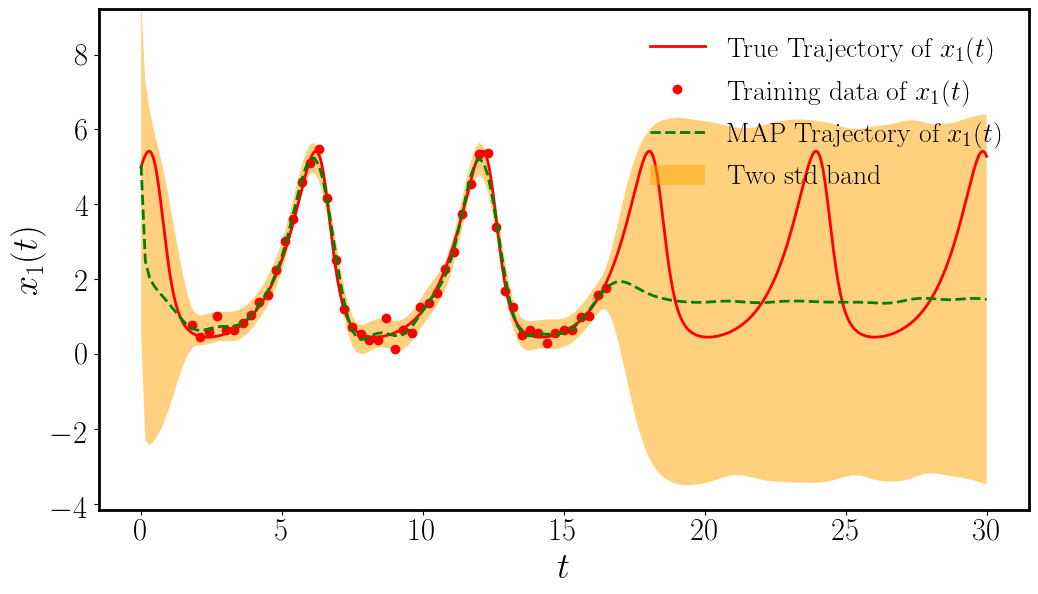

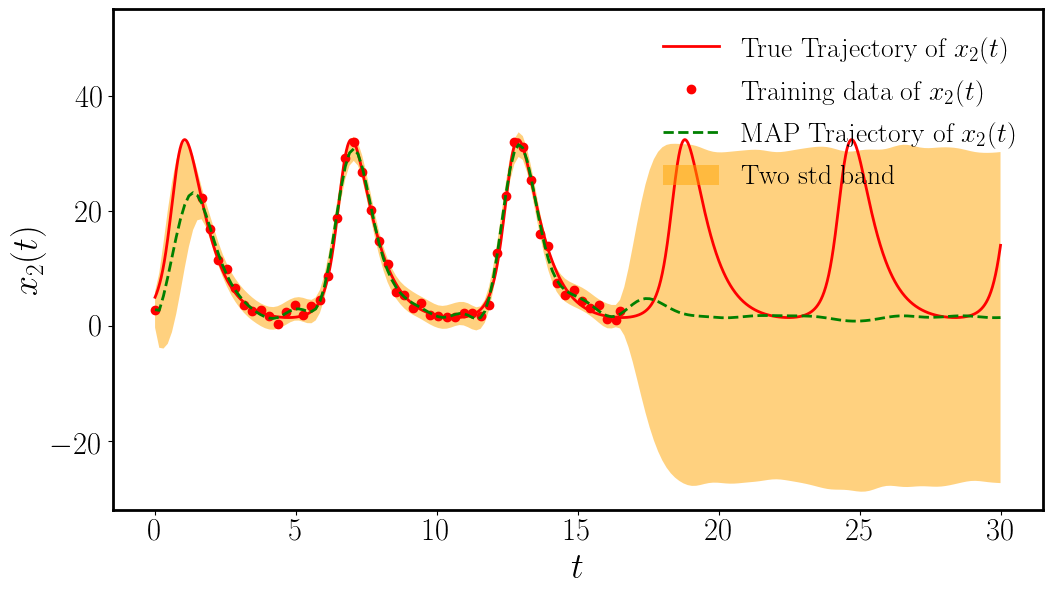

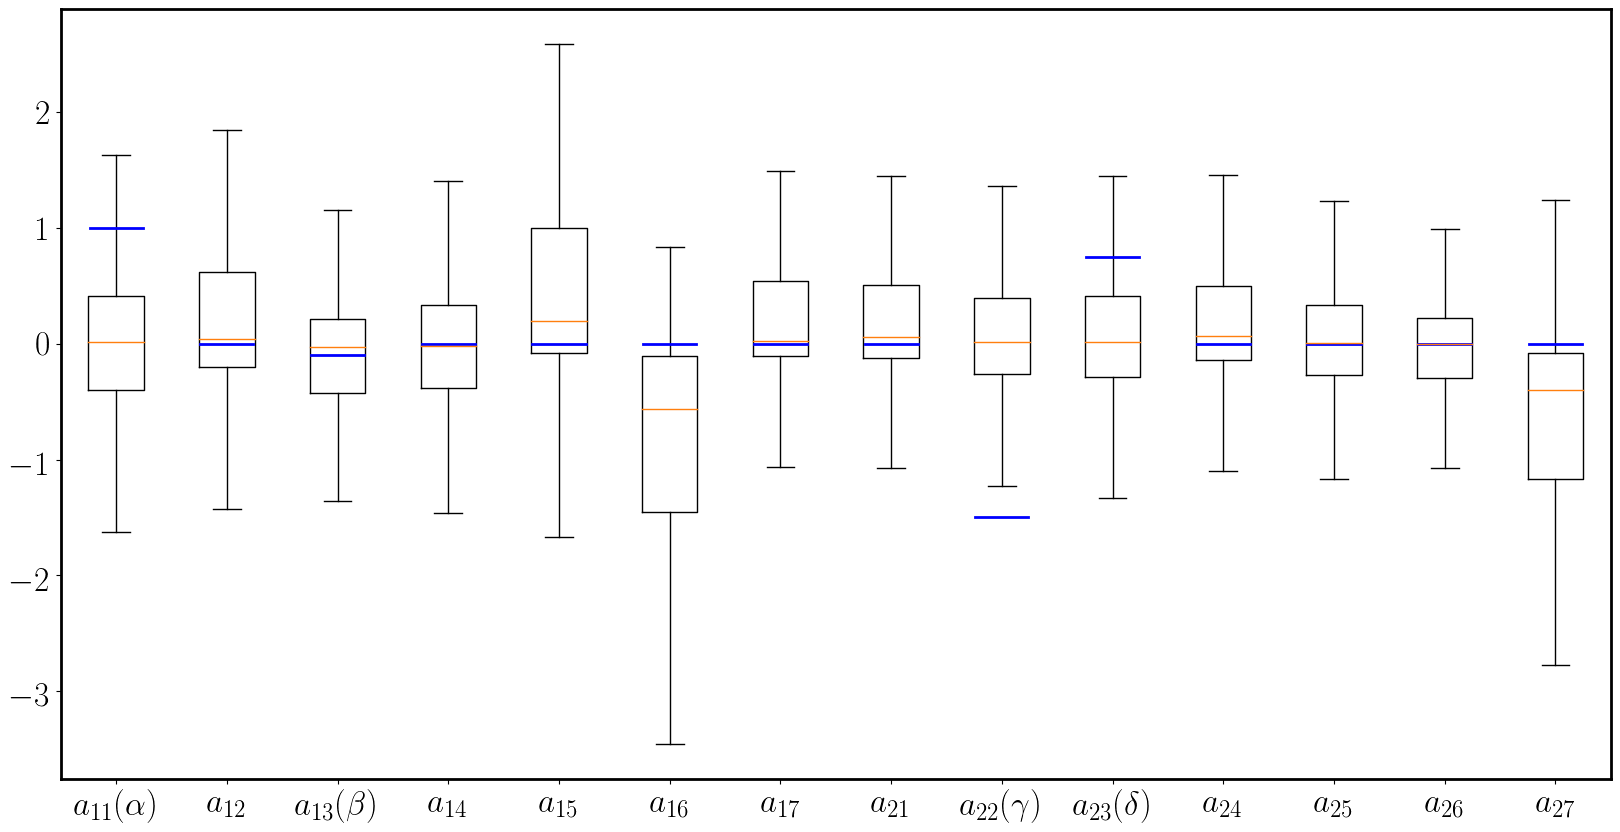

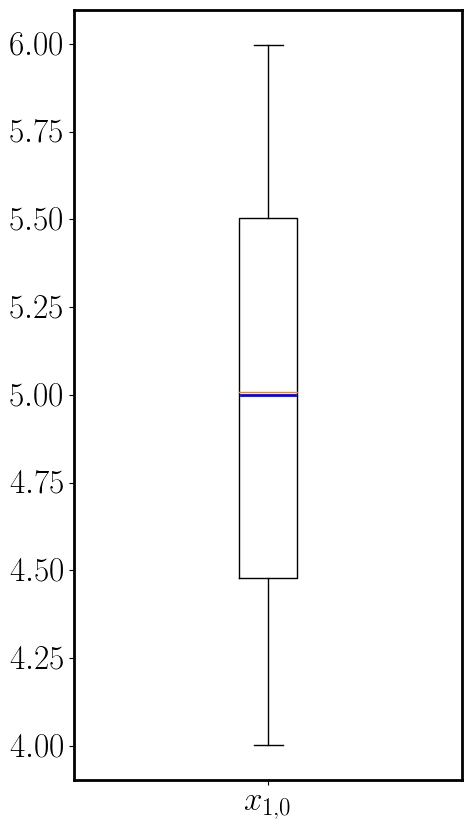

In [77]:
name = [r'$x_{1,0}$']
fig8, ax8 = plt.subplots(figsize=(5, 10))
ax8.boxplot(samples['IC'], showfliers=False, labels=name)
X = np.linspace(0.93, 1.07, 100)[:,None]
plt.plot(X, 5.0*np.ones(X.shape[0]), 'b-')
plt.show()
savefig('plots/box_plot_x0', True)